In [213]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from scipy.integrate import solve_ivp

### Import data

In [246]:
Nanaimo_GridT_Jul21 = xr.open_dataset('/home/cstang/scratch/MEOPAR/results/WWTP/Nanaimo/01jul21_30d_wNutrients_D25/WWTP_1h_20210701_20210731_grid_T.nc')
Nanaimo_GridT_Jan21 = xr.open_dataset('/home/cstang/scratch/MEOPAR/results/WWTP/Nanaimo/01jan21_30d_wNutrients_D25/WWTP_1h_20210101_20210130_grid_T.nc')

WWInput = xr.open_dataset('/home/cstang/MEOPAR/rivers-climatology/WWTP/wastewaterNanaimo_20240601_wNutrients.nc')

mesh = xr.open_dataset('/home/cstang/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]

Nanaimo_X,Nanaimo_Y = 215,498

## Theory, based on Morton et al. 1956

In [269]:
DepthIdx = 25
depth_outfall = 67
Tp_init = WWInput.temperature[6,Nanaimo_Y,Nanaimo_X].values
z_levels = mesh.gdepw_1d[0,0:26] # not inclusive of 26
Sp_init = 0
rho_ref = 1000
g = 9.81
alpha = 0.1

rho_fresh = gsw.rho(0,Tp_init,depth_outfall)

### Initial Conditions
Q0 = WWInput.flux[6,Nanaimo_Y,Nanaimo_X].values*500*440/1025
R = 3 / 2 #of pipe
Area = (R)**2
w0 = Q0/Area

## Ambient temperature
region_temp = Nanaimo_GridT_Jul21.votemper[0,:,Nanaimo_Y-3:Nanaimo_Y+3,Nanaimo_X-3:Nanaimo_X+3]
Tamb = region_temp.where(region_temp > 0, drop=True).mean(dim=['x','y'])

## Ambient salinity
region_sal = Nanaimo_GridT_Jul21.vosaline[0,:,Nanaimo_Y-3:Nanaimo_Y+3,Nanaimo_X-3:Nanaimo_X+3]
Samb = region_sal.where(region_sal > 0, drop=True).mean(dim=['x','y'])

## Ambient density
region_rho = Nanaimo_GridT_Jul21.sigma_theta[0,:,Nanaimo_Y-3:Nanaimo_Y+3,Nanaimo_X-3:Nanaimo_X+3]
rho_amb = region_rho.where(region_rho > 0, drop=True).mean(dim=['x','y']) + 1000
gp_init = g*(rho_amb[25].values - rho_fresh)/rho_ref

### Buoyancy Frequency

drho_amb = np.zeros(25)
z_levels_idx = np.arange(25,0,-1)

for ii,z_idx in enumerate(z_levels_idx):
    drho_amb[z_idx-1] = rho_amb[z_idx] - rho_amb[z_idx-1]
    
N2 = -9.81/rho_ref * drho_amb

dT_amb = np.zeros(25)
z_levels_idx = np.arange(25,0,-1)

for ii,z_idx in enumerate(z_levels_idx):
    dT_amb[z_idx-1] = Tamb[z_idx] - Tamb[z_idx-1]
    
dS_amb = np.zeros(25)

for ii,z_idx in enumerate(z_levels_idx):
    dS_amb[z_idx-1] = Samb[z_idx] - Samb[z_idx-1]

In [ ]:
##Initial Q,M,B
Q0 = R**2*w0
B0 = gp_init*w0*R**2
M0 = w0**2*R**2
Q0,B0,M0

(np.float64(0.32321759259259264),
 np.float64(0.07913441817270452),
 np.float64(0.04643093873837831))

## Equations with gprime

In [270]:
def rhs_wg(zz, y):
    bb, uu, gg = y
    depth = depth_outfall - zz
    n2_a = np.interp(depth, mesh.gdepw_1d[0,:25], N2)

    dbdz = 2*alpha - gg*bb/(2*uu**2)
    dudz = gg/uu - 2*alpha*uu/bb
    dgdz = n2_a - gg*2*alpha/bb
    
    ## calculate q,m,b for comparison
    # qq = uu*bb**2
    # mm = uu**2*bb**2
    # buoy = gg*uu*bb**2
    
    return [dbdz,dudz,dgdz]

z_start = 0
z_end   = depth_outfall

z_steps_wg = np.arange(z_start, z_end, 0.05)
sol_wg = solve_ivp(rhs_wg, (z_start, z_end), [R,w0,gp_init], t_eval=z_steps_wg,rtol=1e-4,atol=1e-7)

b_sol_wg = sol_wg.y[0,:]
w_sol_wg = sol_wg.y[1,:]
g_sol_wg = sol_wg.y[2,:]


cut_wg = len(b_sol_wg)
q_sol_wg = b_sol_wg**2


##Calculate momentum,buoyancy,volumetric flowrate
Q_sol_wg = w_sol_wg*b_sol_wg**2
M_sol_wg = w_sol_wg**2*b_sol_wg**2
B_sol_wg = g_sol_wg*w_sol_wg*b_sol_wg**2


## Calculate density from g' solution
rhoa_sol_wg = np.zeros_like(g_sol_wg) # Calculate ambient density for each step 

for ii in range(cut_wg):
    DIdx = np.argmin(np.abs((depth_outfall-z_steps_wg[ii])-mesh.gdepw_1d[0]).values)
    rhoa_sol_wg[ii] = rho_amb[DIdx]
    
rho_sol_wg = rhoa_sol_wg - rho_ref*g_sol_wg/g

Text(0, 0.5, 'Distance from outfall')

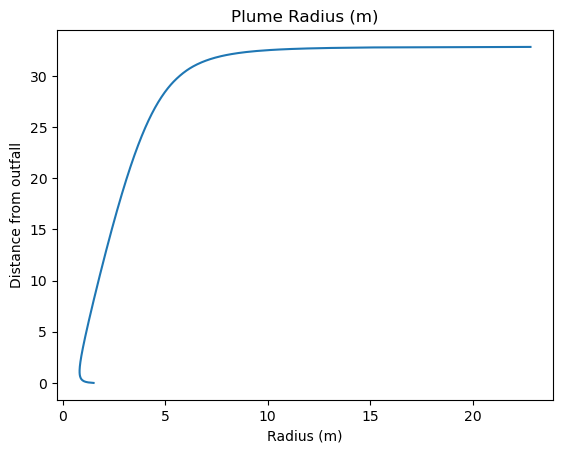

In [251]:
plt.plot(b_sol_wg,z_steps_wg[:cut_wg])
plt.title('Plume Radius (m)')
plt.xlabel('Radius (m)')
plt.ylabel('Distance from outfall')

Text(0, 0.5, 'Distance from outfall')

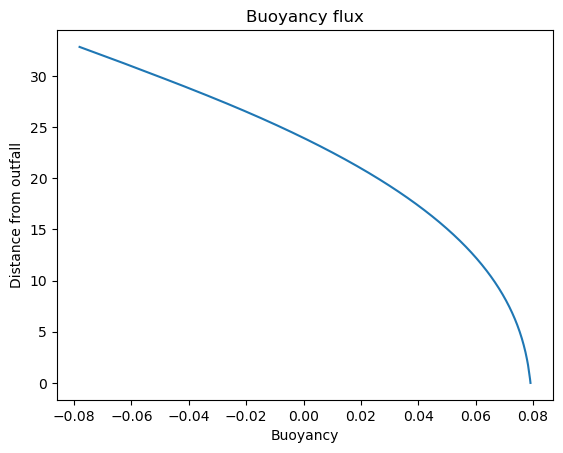

In [252]:
plt.plot(B_sol_wg,z_steps_wg[:cut_wg])
plt.title('Buoyancy flux')
plt.xlabel('Buoyancy')
plt.ylabel('Distance from outfall')

Text(0, 0.5, 'Distance from outfall')

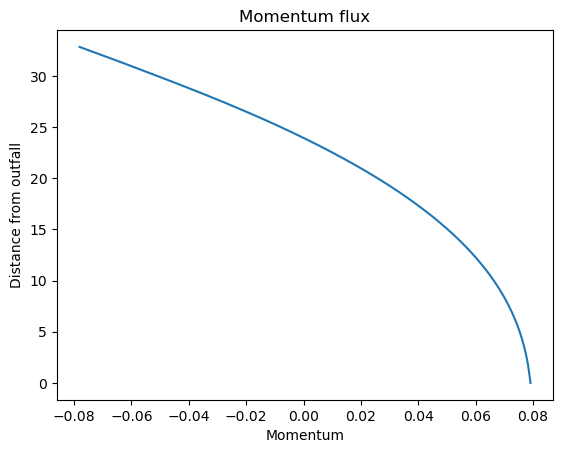

In [253]:
plt.plot(B_sol_wg,z_steps_wg[:cut_wg])
plt.title('Momentum flux')
plt.xlabel('Momentum')
plt.ylabel('Distance from outfall')

## Try with temp, salinity equations instead

In [255]:
def rhs_ts(zz, y):
    bb,uu,tp,sp = y
    depth = depth_outfall - zz
    rho_p = gsw.rho(sp,tp,0)
    ta = np.interp(depth, mesh.gdepw_1d[0,:33], Tamb)
    sa = np.interp(depth, mesh.gdepw_1d[0,:33], Samb)
    rho_a = np.interp(depth, mesh.gdepw_1d[0,:33], rho_amb)
    rho_a = gsw.rho(sa,ta,0)
    # dt_a = np.interp(depth, mesh.gdepw_1d[0,:25], dT_amb)
    # ds_a = np.interp(depth, mesh.gdepw_1d[0,:25], dS_amb)
    
    
    dbdz = 2*alpha - g*(rho_a-rho_p)/rho_ref*bb/(2*uu**2)
    dudz = g*(rho_a-rho_p)/rho_ref/uu - 2*alpha*uu/bb
    dtdz = 2*alpha/bb*(ta - tp) 
    dsdz = 2*alpha/bb*(sa - sp) 
    # gg = g*(rho_a - rho_p)/rho_ref
    # dggdz = n2_a - gg*2*alpha/bb
    
    return [dbdz,dudz,dtdz,dsdz]

z_start = 0
z_end   = depth_outfall

z_steps_ts = np.arange(z_start, z_end, 0.05)
sol_ts = solve_ivp(rhs_ts, (z_start, z_end), [R,w0,Tp_init,0], t_eval=z_steps_ts,rtol=1e-4,atol=1e-7)

b_sol_ts = sol_ts.y[0,:]
w_sol_ts = sol_ts.y[1,:]
t_sol_ts = sol_ts.y[2,:]
s_sol_ts = sol_ts.y[3,:]

## Calculate density from T,S solutions
cut_ts = len(b_sol_ts)
rho_sol_ts = gsw.rho(s_sol_ts,t_sol_ts,67-z_steps_ts[:cut_ts])

## Calculate Q,M from r,w solutions
Q_sol_ts = w_sol_ts*b_sol_ts**2
M_sol_ts = w_sol_ts**2*b_sol_ts**2

## Calculate g from density
rhoa_sol_ts = np.zeros_like(t_sol_ts) # Find ambient density for each solution point

for ii in range(cut_ts):
    rhoa_sol_ts[ii] = np.interp(67-z_steps_ts[ii], mesh.gdepw_1d[0,:33], rho_amb)
    
g_sol_ts = g*(rhoa_sol_ts - rho_sol_ts)/rho_ref
B_sol_ts = g_sol_ts*w_sol_ts*b_sol_ts**2

Text(0, 0.5, 'Depth')

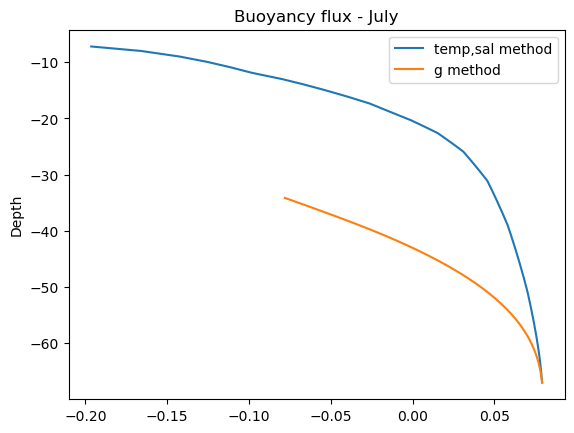

In [256]:
plt.plot(B_sol_ts,z_steps_ts[:cut_ts]-67,label='temp,sal method')
plt.plot(B_sol_wg,z_steps_wg[:cut_wg]-67,label='g method')
plt.legend()
plt.title('Buoyancy flux - July')
plt.ylabel('Depth')

Text(0, 0.5, 'Depth')

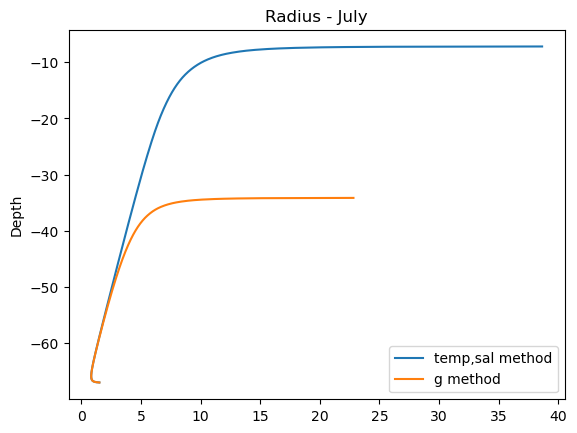

In [257]:
plt.plot(b_sol_ts,z_steps_ts[:cut_ts]-67,label='temp,sal method')
plt.plot(b_sol_wg,z_steps_wg[:cut_wg]-67,label='g method')
plt.legend()
plt.title('Radius - July')
plt.ylabel('Depth')

Text(0.5, 0, 'Density')

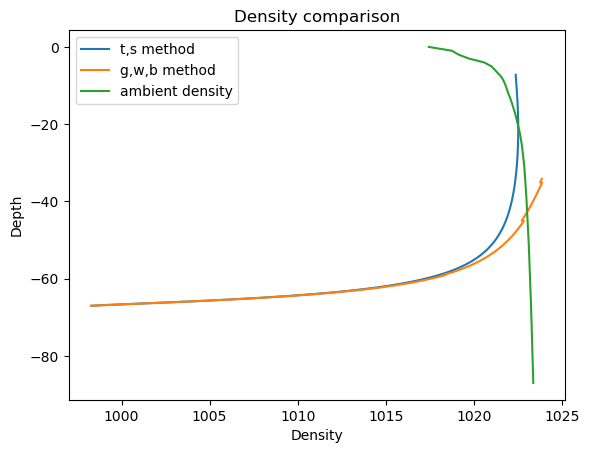

In [258]:
plt.plot(rho_sol_ts,z_steps_ts[:cut_ts]-67,label='t,s method')
plt.plot(rho_sol_wg,z_steps_wg[:cut_wg]-67,label='g,w,b method')
plt.plot(rho_amb[:27],-mesh.gdepw_1d[0,:27],label='ambient density')
# plt.plot(rhoa_sol_ts,z_steps_ts[:cut_ts]-67)
plt.legend()
plt.ylabel('Depth')
plt.title('Density comparison')
plt.xlabel('Density')

In [260]:
# Calculate ambient temp and sal for each solution point

Tamb_sol_ts = np.zeros_like(t_sol_ts) 

for ii in range(cut_ts):
    Tamb_sol_ts[ii] = np.interp(depth_outfall-z_steps_ts[ii], mesh.gdepw_1d[0,:33], Tamb)
    
Samb_sol_ts = np.zeros_like(t_sol_ts) 

for ii in range(cut_ts):
    Samb_sol_ts[ii] = np.interp(depth_outfall-z_steps_ts[ii], mesh.gdepw_1d[0,:33], Samb)

Text(0.5, 0, 'Temperature')

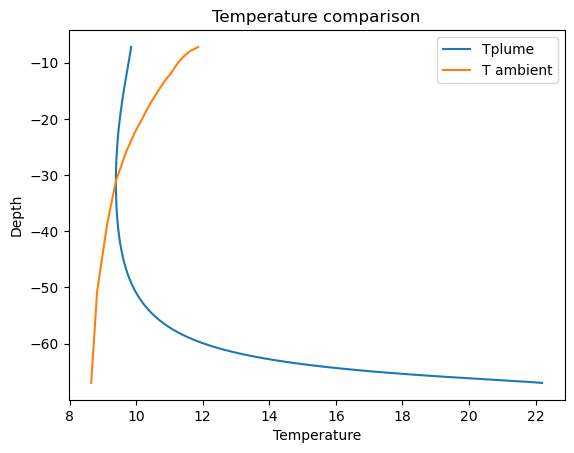

In [267]:
plt.plot(t_sol_ts,z_steps_ts[:cut_ts]-67,label='Tplume')
plt.plot(Tamb_sol_ts,z_steps_ts[:cut_ts]-depth_outfall,label='T ambient')

plt.legend()
plt.ylabel('Depth')
plt.title('Temperature comparison')
plt.xlabel('Temperature')

Text(0.5, 0, 'Salinity')

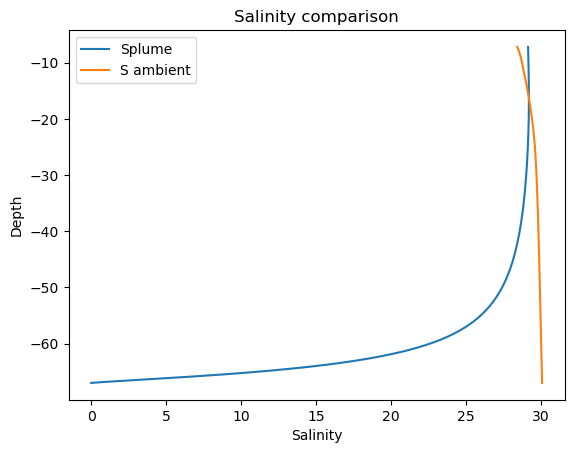

In [268]:
plt.plot(s_sol_ts,z_steps_ts[:cut_ts]-67,label='Splume')
plt.plot(Samb_sol_ts,z_steps_ts[:cut_ts]-depth_outfall,label='S ambient')

plt.legend()
plt.ylabel('Depth')
plt.title('Salinity comparison')
plt.xlabel('Salinity')